In [11]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import partial_rankings as prank
import random

In [20]:
# utils functions

def merge(left, right):
    """
    This function uses Merge sort algorithm to count the number of
    inversions in a permutation of two parts (left, right).
    Parameters
    ----------
    left: ndarray
        The first part of the permutation
    right: ndarray
        The second part of the permutation
    Returns
    -------
    result: ndarray
        The sorted permutation of the two parts
    count: int
        The number of inversions in these two parts.
    """
    result = []
    count = 0
    i, j = 0, 0
    left_len = len(left)
    while i < left_len and j < len(right):
        if left[i] <= right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            count += left_len - i
            j += 1
    result += left[i:]
    result += right[j:]

    return result, count

def mergeSort_rec(lst):
    """
    This function splits recursively lst into sublists until sublist size is 1. Then, it calls the function merge()
    to merge all those sublists to a sorted list and compute the number of inversions used to get that sorted list.
    Finally, it returns the number of inversions in lst.
    Parameters
    ----------
    lst: ndarray
        The permutation
    Returns
    -------
    result: ndarray
        The sorted permutation
    d: int
        The number of inversions.
    """
    lst = list(lst)
    if len(lst) <= 1:
        return lst, 0
    middle = int( len(lst) / 2 )
    left, a   = mergeSort_rec(lst[:middle])
    right, b  = mergeSort_rec(lst[middle:])
    sorted_, c = merge(left, right)
    d = (a + b + c)
    return sorted_, d

def distance(A, B=None):
    """
    This function computes Kendall's-tau distance between two permutations
    using Merge sort algorithm.
    If only one permutation is given, the distance will be computed with the
    identity permutation as the second permutation
   Parameters
   ----------
   A: ndarray
        The first permutation
   B: ndarray, optional
        The second permutation (default is None)
   Returns
   -------
   int
        Kendall's-tau distance between both permutations (equal to the number of inversions in their composition).
    """
    if B is None : B = list(range(len(A)))

    A = np.asarray(A).copy()
    B = np.asarray(B).copy()
    n = len(A)

    # check if A contains NaNs
    msk = np.isnan(A)
    indexes = np.array(range(n))[msk]

    if indexes.size:
        A[indexes] = n#np.nanmax(A)+1

    # check if B contains NaNs
    msk = np.isnan(B)
    indexes = np.array(range(n))[msk]

    if indexes.size:
        B[indexes] = n#np.nanmax(B)+1

    # print(A,B,n)
    inverse = np.argsort(B)
    compose = A[inverse]
    _, distance = mergeSort_rec(compose)
    return distance

def v_to_ranking(v, n):
    """This function computes the corresponding permutation given a decomposition vector.
    The O(n log n) version in 10.1.1 of
    Arndt, J. (2010). Matters Computational: ideas, algorithms, source code.
    Springer Science & Business Media.
        Parameters
        ----------
        v: ndarray
            Decomposition vector, same length as the permutation, last item must be 0
        n: int
            Length of the permutation
        Returns
        -------
        ndarray
            The permutation corresponding to the decomposition vectors.
    """
    rem = list(range(n))
    rank = np.full(n, np.nan)
    for i in range(len(v)):
        rank[i] = rem[v[i]]
        rem.pop(v[i])
    return rank.astype(int)
def theta_to_phi(theta):
    """This functions converts theta dispersion parameter into phi
        Parameters
        ----------
        theta: float
            Real dispersion parameter
        Returns
        -------
        float
            phi real dispersion parameter
    """
    return np.exp(-theta)
def phi_to_theta(phi):
    """This functions converts phi dispersion parameter into theta
        Parameters
        ----------
        phi: float
            Real dispersion parameter
        Returns
        -------
        float
            theta real dispersion parameter
    """
    return -np.log(phi)
def check_theta_phi(theta, phi):
    """This function automatically converts theta to phi or phi to theta as
    list or float depending on the values and value types given as input
        Parameters
        ----------
        theta: float or list
            Dispersion parameter theta to convert to phi (can be None)
        phi: float or list
            Dispersion parameter phi to convert to theta (can be None)
        Returns
        -------
        tuple
            tuple containing both theta and phi (of list or float type depending on the input type)
    """
    if not ((phi is None) ^ (theta is None)):
        print("Set valid values for phi or theta")
    if phi is None and type(theta)!=list:
        phi = theta_to_phi(theta)
    if theta is None and type(phi)!=list:
        theta = phi_to_theta(phi)
    if phi is None and type(theta)==list:
        phi = [theta_to_phi(t) for t in theta]
    if theta is None and type(phi)==list:
        theta = [phi_to_theta(p) for p in phi]
    return theta, phi

def expected_dist_mm(n, theta=None, phi=None):
    """The function computes the expected distance of Kendall's-tau distance under Mallows models (MMs).
        Parameters
        ----------
        n: int
            Length of the permutation in the considered model
        theta: float
            Real dispersion parameter, optional (if phi is given)
        phi: float
            Real dispersion parameter, optional (if theta is given)
        Returns
        -------
        float
            The expected distance under MMs.
    """
    theta, phi = check_theta_phi(theta, phi)
    rnge = np.array(range(1,n+1))
    expected_dist = n * np.exp(-theta) / (1-np.exp(-theta)) - np.sum(rnge * np.exp(-rnge*theta) / (1 - np.exp(-rnge*theta)))

    return expected_dist

def sample(m, n, *, k=None, theta=None, phi=None, s0=None):
    """This function generates m (rankings) according to Mallows Models (if the given parameters
    are m, n, k/None, theta/phi: float, s0/None) or Generalized Mallows Models (if the given
    parameters are m, n, theta/phi: ndarray, s0/None). Moreover, the parameter k allows the
    function to generate top-k rankings only.
        Parameters
        ----------
        m: int
            Number of rankings to generate
        n: int
            Length of rankings
        theta: float or ndarray, optional (if phi given)
            The dispersion parameter theta
        phi: float or ndarray, optional (if theta given)
            Dispersion parameter phi
        k: int
            Length of partial permutations (only top items)
        s0: ndarray
            Consensus ranking
        Returns
        -------
        ndarray
            The rankings generated
    """

    theta, phi = check_theta_phi(theta, phi)

    theta = np.full(n-1, theta)

    if s0 is None:
        s0 = np.array(range(n))

    rnge = np.array(range(n-1))

    psi = (1 - np.exp(( - n + rnge )*(theta[ rnge ])))/(1 - np.exp( -theta[rnge]))
    vprobs = np.zeros((n, n))
    for j in range(n-1):
        vprobs[j][0] = 1.0/psi[j]
        for r in range(1, n-j):
            vprobs[j][r] = np.exp( -theta[j] * r ) / psi[j]
    sample = []
    vs = []
    for samp in range(m):
        v = [np.random.choice(n, p=vprobs[i, :]) for i in range(n-1)]
        v += [0]
        ranking = v_to_ranking(v, n)
        sample.append(ranking)

    sample = np.array([s[s0] for s in sample])

    if k is not None:
        sample_rankings = np.array([pu.inverse(ordering) for ordering in sample])
        sample_rankings = np.array([ran[s0] for ran in sample_rankings])
        sample = np.array([[i if i in range(k) else np.nan for i in ranking] for
                        ranking in sample_rankings])
    return sample

# Confidence Intervals

### Empirical evaluation of the CI
Paper: Preference-Based Rank Elicitation using Statistical Models, Thm 4 (also Algorithm 1, line 8)

just to see the numbers

n_ij= 100 , CI= 0.2958410892022794
n_ij= 150 , CI= 0.24708514206169593
n_ij= 200 , CI= 0.2173170746466905


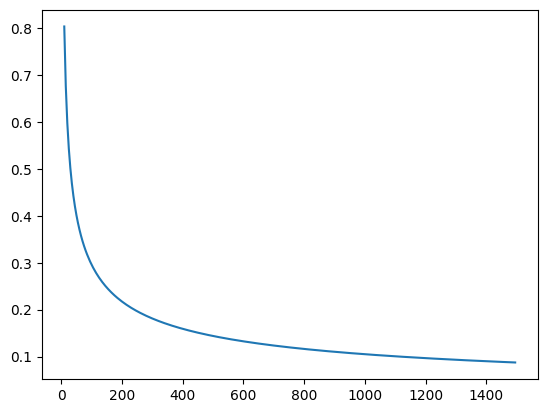

In [13]:
M = 1500
delta = .01
n = 10
cis = []
n_ijs = np.arange(10,M,5)
for n_ij in n_ijs:
  CI = np.sqrt( 1/(2*n_ij) * np.log( (4 * n * n_ij**2)/delta))
  if n_ij in [100,150,200]: 
    print("n_ij=",n_ij,", CI=",CI)
  cis.append(CI)
plt.plot(n_ijs,cis)
plt.show()

## Generate synthetic data
generates complete data and then censores them. 

- The permus are centered aroud the identity (1,2,3,...n). 
- The censoring is done assumming that the users rank the top and the bottom items with highe probabiity (but hose items in the center of the ranking are probablu not observed). 

**dependecies**: top-k-mallows. 

You can avoind this cell by loading the data in *np.savetxt('p_rankings.txt', p_ranks)*

In [14]:
# this simulates a dataset and censores it deleting random data. 
# dependencies:  top-k-mallows 
# uncomment to run all, otherwise, the data is 
# dataset center and E[d]:  [5 1 9 3 6 4 7 0 8 2] 0.46619496647975145
np.random.seed(42)
random.seed(42)
# create a dataset and censore it 
m = 200
n = 10
verbose = True
theta_mm = 1
center = np.arange(n)# np.random.permutation(n)#np.array([5,6,7,8,9,0,1,2,3,4]) #
sample = sample(m=m,n=n,theta=theta_mm, s0=center)
print("dataset center and E[d]: ",center,  expected_dist_mm(n, theta_mm))

p_ranks = []
perm = sample[0].copy()
if m>10: verbose = False
for perm in sample:
  perm = perm.astype(float)
  if verbose:print(perm)
  # create a mask to censore the permutation: The rankings with True will be deketed
  ###censoring distribution 1   # proba of True is unif for all positions. 
  mask = np.random.choice([0, 1], size=(n), p=[7/10, 3/10]).astype(bool) 
  ####censoring distribution 2   #probability of True linearli increasing form 0 to 1
  #mask = [ np.random.choice([0, 1], size=1, p=[1-i/n,i/n])[0] for i in range(n)] 
  #mask = np.array(mask).astype(bool)
  #### censoring distri 3 : mainly rank the best and the wordt, not the middle items
  #probas_mask = norm.pdf(np.linspace(-3,3,n)) # follow a gaussian for the proba of observing
  #rands = np.random.rand(n)
  #mask = probas_mask>rands
  ####censoring distribution 4: full permutations
  #mask = np.full(n,False) # no mask
  k = n - mask.sum() - 1 
  perm[mask] = np.nan
  if verbose:print(perm)
  perm = np.argsort(np.argsort(perm)).astype(float)
  if verbose:print(perm)
  perm[perm>k]=np.nan
  if verbose:print(perm)
  p_ranks.append(perm)
p_ranks = np.array(p_ranks)

p_ranks
# np.savetxt('p_rankings.txt', p_ranks)
# np.savetxt('p_center.txt', center)


dataset center and E[d]:  [0 1 2 3 4 5 6 7 8 9] 4.63347235431026


array([[nan, nan, 1.00, ..., 5.00, 4.00, 6.00],
       [0.00, nan, 3.00, ..., nan, 5.00, 6.00],
       [0.00, 1.00, 2.00, ..., nan, nan, 6.00],
       ...,
       [2.00, nan, 0.00, ..., 3.00, 4.00, nan],
       [0.00, 2.00, 3.00, ..., 5.00, 6.00, nan],
       [1.00, 0.00, 2.00, ..., 6.00, 7.00, 8.00]])

## Compute Borda and confidence intervals for evary pair

In [15]:
def build_CI(p_total, comp_total, delta=.1, center=None):
  n = len(p_total[0])
  borda_rank = prank.borda_mat(p_total)
  if center is not None:
    print("Estimated central ranking:",borda_rank)
    print("Its distance to the Groupnd-truth) center/ maximal distance",distance(borda_rank,center),round(n*(n-1)/2,2) )

  CIs = np.zeros((n,n))
  for i in range(n):
    for j in range(i+1,n):
      CIs[i,j] = np.sqrt( - np.log(delta)/(2*comp_total[i,j]))
      CIs[j,i] = CIs[i,j]
  return p_total,CIs

p_total = np.zeros((n,n)) # p_total[i,j] counts the number of times i IS PREFERRED to j
comp_total = np.zeros((n,n)) # comp_total[i,j] counts the number of times i HAS BEEN COMPARED to j (= num of permus in which they are both non nan)
for perm in p_ranks:
  p, comp, _ = prank.p_rank_to_mat(perm, return_ratios=True, return_num_comparisons=True)
  p = p.astype(float)
  comp_total = comp_total+ comp
  p_total =p_total+ p
p_total = (p_total/len(p_ranks))
p_total,CIs = build_CI(p_total, comp_total, delta=.01, center=center)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
p_total, CIs, comp_total

Estimated central ranking: [0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00]
Its distance to the Groupnd-truth) center/ maximal distance 0 45.0


(array([[0.00, 0.63, 0.70, 0.75, 0.78, 0.82, 0.83, 0.86, 0.87, 0.89],
        [0.37, 0.00, 0.60, 0.66, 0.71, 0.75, 0.77, 0.83, 0.83, 0.85],
        [0.30, 0.40, 0.00, 0.63, 0.69, 0.74, 0.78, 0.83, 0.83, 0.85],
        [0.25, 0.34, 0.37, 0.00, 0.61, 0.72, 0.75, 0.80, 0.80, 0.85],
        [0.22, 0.29, 0.31, 0.39, 0.00, 0.66, 0.71, 0.77, 0.77, 0.82],
        [0.18, 0.25, 0.26, 0.28, 0.34, 0.00, 0.58, 0.71, 0.71, 0.79],
        [0.17, 0.23, 0.22, 0.25, 0.29, 0.42, 0.00, 0.66, 0.68, 0.76],
        [0.14, 0.17, 0.17, 0.20, 0.23, 0.29, 0.34, 0.00, 0.62, 0.71],
        [0.13, 0.17, 0.17, 0.20, 0.23, 0.29, 0.32, 0.38, 0.00, 0.63],
        [0.11, 0.15, 0.15, 0.15, 0.18, 0.21, 0.24, 0.29, 0.37, 0.00]]),
 array([[0.00, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.14, 0.15, 0.15],
        [0.16, 0.00, 0.16, 0.16, 0.17, 0.16, 0.16, 0.15, 0.16, 0.15],
        [0.15, 0.16, 0.00, 0.15, 0.17, 0.16, 0.15, 0.15, 0.16, 0.15],
        [0.15, 0.16, 0.15, 0.00, 0.15, 0.15, 0.15, 0.14, 0.15, 0.14],
        [0.15, 0.1

## Visualization



Estimated central ranking: [0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00]
Its distance to the Groupnd-truth) center/ maximal distance 0 45.0


<AxesSubplot: >

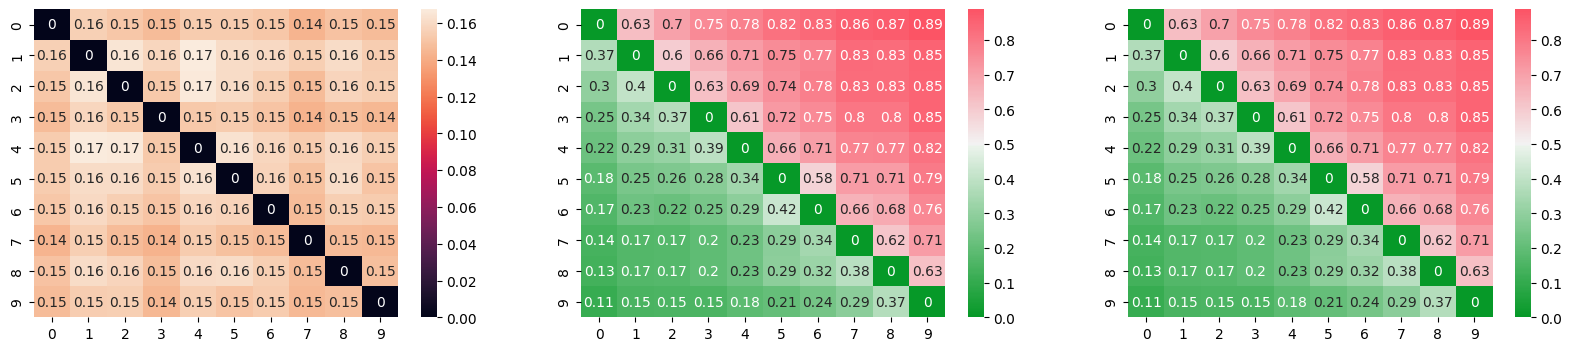

In [16]:
p_total,CIs = build_CI(p_total, comp_total, delta=.01, center=center)
rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
fig,  ax = plt.subplots(1,  3,  figsize=(20,  4))
sns.heatmap(CIs, annot=True, ax=ax[0])
sns.heatmap(p_total, annot=True, cmap=rdgn, center=0.5, ax=ax[1])
sns.heatmap(p_total[np.ix_(np.argsort(center), np.argsort(center))], annot=True, cmap=rdgn, center=0.5, ax=ax[2]) 

## is .5 in the CI?

If 0.5 is not in the CI then we can say that we can guarantww that i is better than j

red is it is. fits the model in which we only vote for the most referred and the less preferred  items

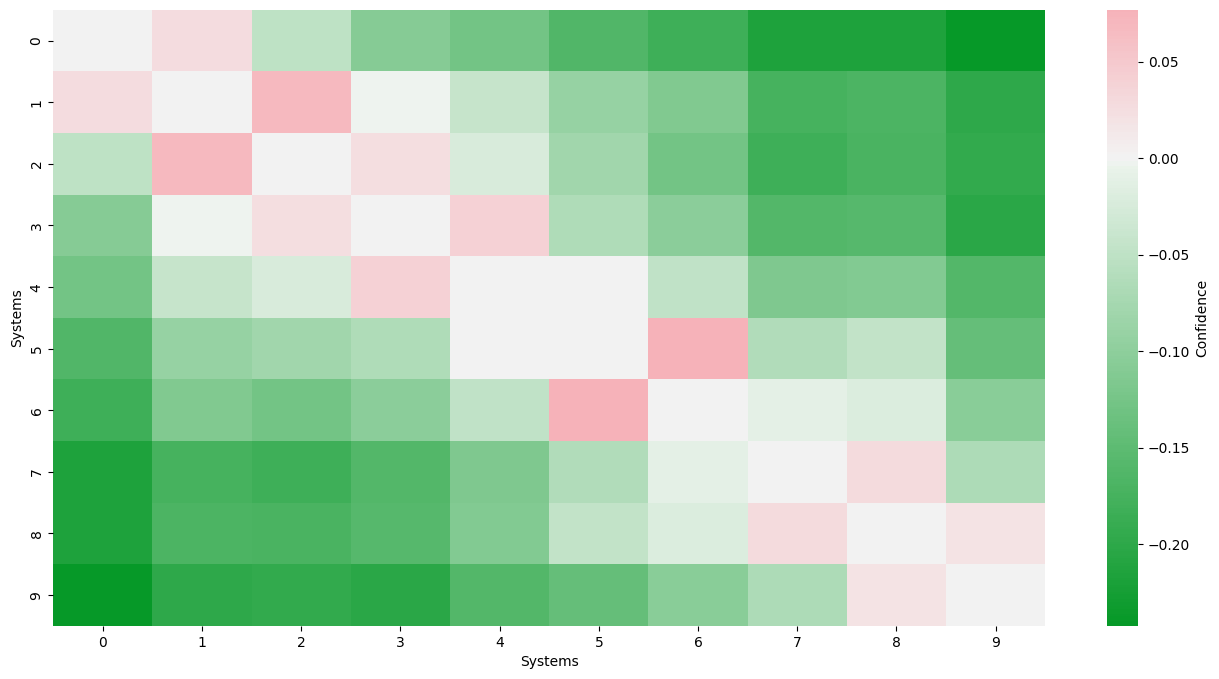

In [17]:
def pairwise_decission(p_total, CIs , center):
  #print("We plot as a heatmap, in red for .5\in the CI, green if not. With the rows and cols properly reordrered, close to the diagonal is more  blurry")
  CI_dist = np.zeros((n,n))
  for i in range(n):
    for j in range(i+1,n):
      a = ( p_total[i,j] - CIs[i,j] )
      b = ( p_total[i,j] + CIs[i,j] )
      closest_bound = min(abs(a-.5),abs(b-.5))
      if a<.5 and .5<b:  
        CI_dist[i,j] = + closest_bound 
        # positive distance, .5 is IN the CI
      else: 
        CI_dist[i,j] = - closest_bound
      CI_dist[j,i] = CI_dist[i,j]

  # print(CI_dist)
  CI_dist = CI_dist[np.ix_(np.argsort(center), np.argsort(center))]
  # print(CI_dist)

  rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
  plt.figure(figsize=(16,8))
  #sns.heatmap(CI_dist, annot=True, cmap=rdgn, center=0)
  # print(CI_dist)
  sns.heatmap(CI_dist, cmap=rdgn, center=0,cbar_kws={'label': 'Confidence'})
  # change the xticks with center
  plt.xticks(np.arange(n)+.5, np.arange(n)[center.astype(int)])
  plt.yticks(np.arange(n)+.5, np.arange(n)[center.astype(int)])

  plt.xlabel("Systems")
  plt.ylabel("Systems")
  # title
  # plt.title("file: "+file)
# print(center)

pairwise_decission(p_total, CIs , center)
# save fig
# plt.savefig("statistical/WMT21-en.de.png", bbox_inches='tight')


# Real instance level data experiment


final_df/MT/WMT21/newstest2021.en-zh.data.csv
Estimated central ranking: [18.00 7.00 5.00 10.00 15.00 8.00 20.00 9.00 6.00 12.00 3.00 24.00 13.00
 25.00 21.00 23.00 14.00 11.00 16.00 0.00 4.00 2.00 26.00 28.00 22.00
 19.00 17.00 27.00 1.00]
Its distance to the Groupnd-truth) center/ maximal distance 0 406.0


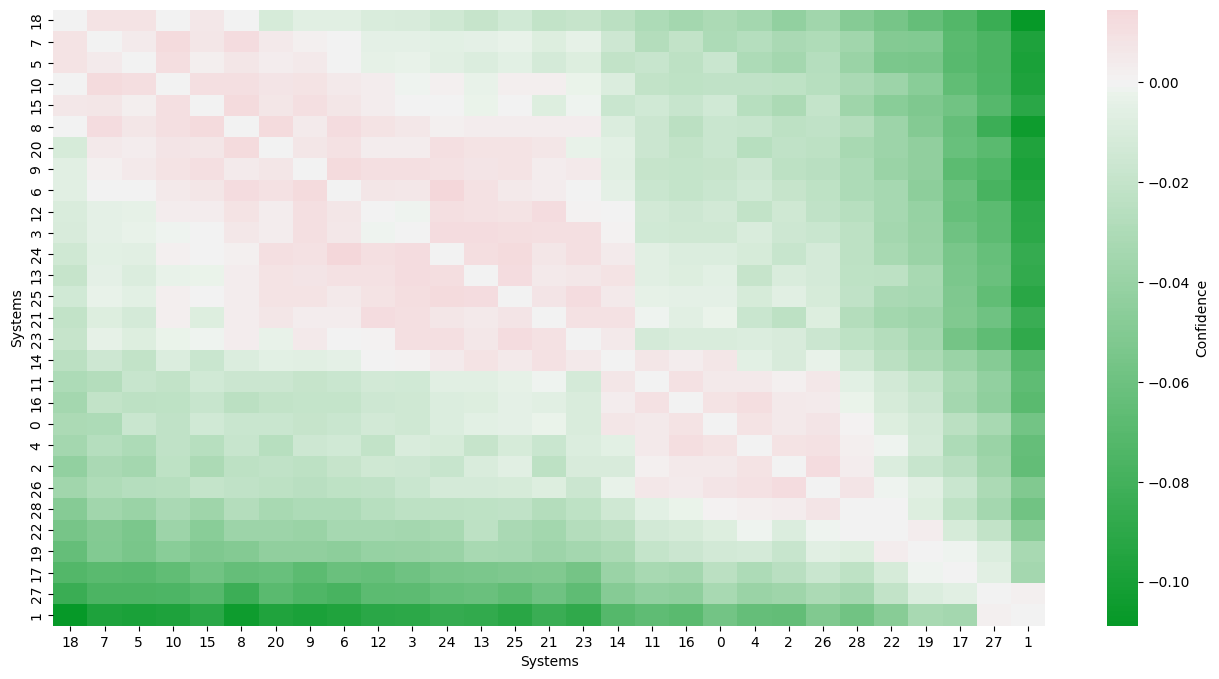

final_df/MT/WMT21/newstest2021.en-ha.data.csv
Estimated central ranking: [10.00 2.00 8.00 0.00 12.00 9.00 3.00 7.00 11.00 1.00 6.00 4.00 13.00 5.00]
Its distance to the Groupnd-truth) center/ maximal distance 0 91.0


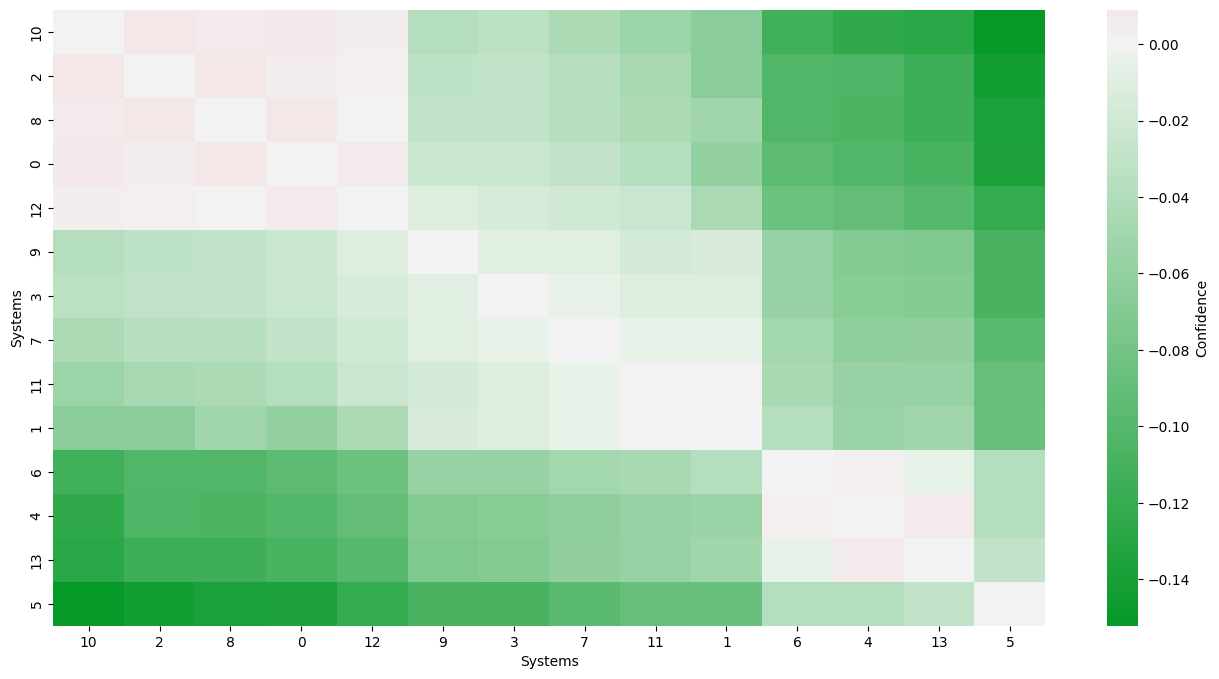

final_df/MT/WMT21/newstest2021.en-de.data.csv
Estimated central ranking: [23.00 1.00 5.00 24.00 13.00 4.00 10.00 14.00 21.00 2.00 17.00 16.00 9.00
 12.00 6.00 3.00 0.00 7.00 20.00 11.00 18.00 22.00 8.00 15.00 19.00]
Its distance to the Groupnd-truth) center/ maximal distance 0 300.0


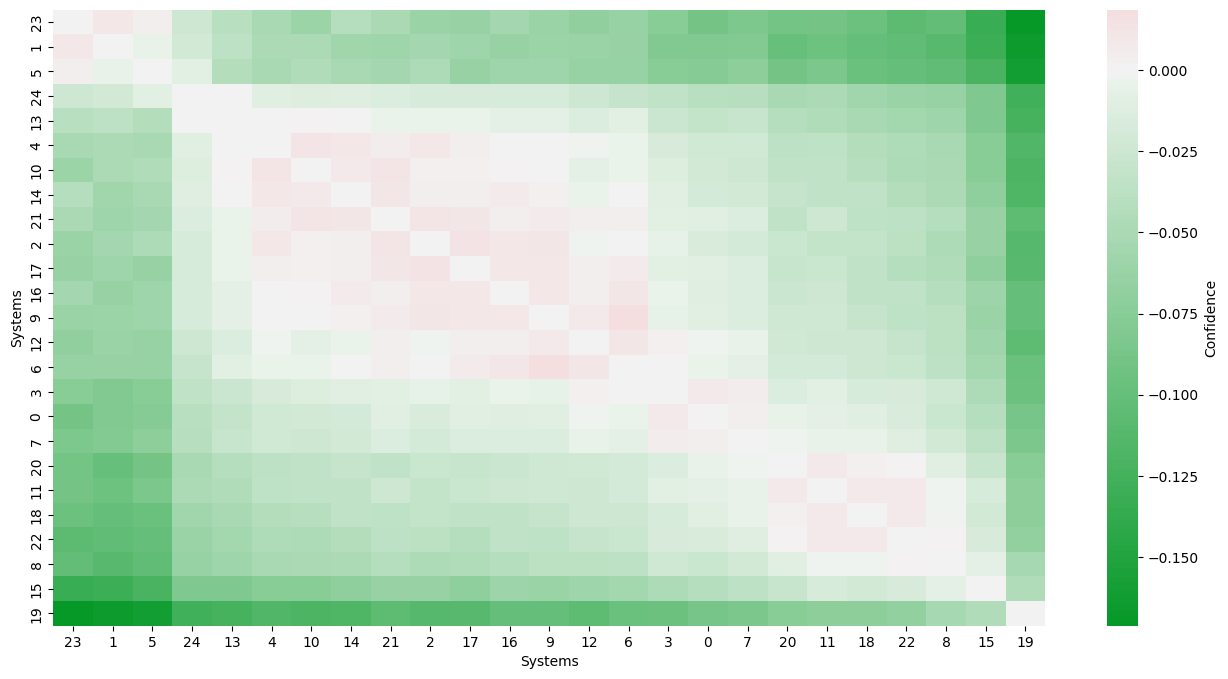

final_df/TAC/TAC_08.csv
Estimated central ranking: [53.00 38.00 31.00 32.00 18.00 8.00 16.00 23.00 41.00 28.00 61.00 7.00
 15.00 40.00 46.00 27.00 17.00 30.00 22.00 14.00 54.00 45.00 49.00 29.00
 48.00 55.00 34.00 47.00 37.00 21.00 43.00 11.00 39.00 59.00 51.00 44.00
 26.00 19.00 5.00 13.00 10.00 25.00 58.00 6.00 9.00 35.00 20.00 24.00
 12.00 57.00 33.00 56.00 50.00 42.00 2.00 3.00 4.00 1.00 0.00 52.00 36.00
 60.00]
Its distance to the Groupnd-truth) center/ maximal distance 0 1891.0


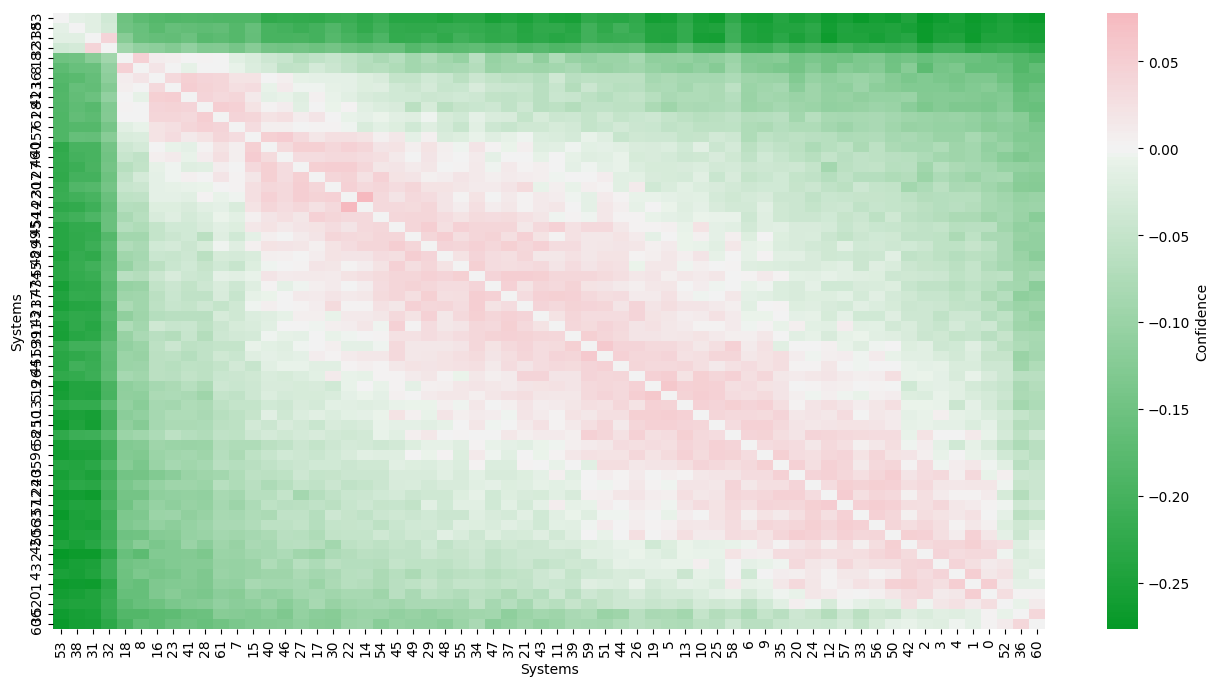

In [18]:
import instance_level_calculate_correlations as corr

files = ["final_df/MT/WMT21/newstest2021.en-zh.data.csv","final_df/MT/WMT21/newstest2021.en-ha.data.csv",
         "final_df/MT/WMT21/newstest2021.en-de.data.csv","final_df/TAC/TAC_08.csv"]
np.random.seed(42)
random.seed(42)
for file in files:
  print(file)
  # preprocess data
  df = corr.load_file(file)

  df = corr.instance_level_remove_system_column(df,0.2)

  p_ranks=[]
  for metric in corr.metric_names:
      if metric in df.columns:
          grouped_df = df.groupby('Utterance')
          p_ranks = p_ranks + [prank.partial_scores_to_ranking(g[metric].values.tolist()) for u, g in grouped_df]

  p_ranks = np.array(p_ranks)
  # print(p_ranks[0])
  # print(p_ranks)
  n = len(p_ranks[0])
  p_total = np.zeros((n,n)) # p_total[i,j] counts the number of times i IS PREFERRED to j
  comp_total = np.zeros((n,n)) # comp_total[i,j] counts the number of times i HAS BEEN COMPARED to j (= num of permus in which they are both non nan)

  for perm in p_ranks:
    p, comp, _ = prank.p_rank_to_mat(perm, return_ratios=True, return_num_comparisons=True)
    # print(p)
    # print(comp)
  #   print(comp)
    comp_total = comp_total+comp
    p_total = p_total + p.astype('float64')
  p_total = (p_total/len(p_ranks))
  # print(comp_total)

  center = prank.borda_mat(p_total)
  # these are the two functions for CI managing. 
  # The code for these ones is above
  p_total,CIs = build_CI(p_total, comp_total, delta=0.01, center=center)
  pairwise_decission(p_total, CIs , center)
  # get filename with extension
  filename = file.split('/')[-1][:-4]
  # print(filename)
  plt.savefig("statistical/"+filename+"_2.png", bbox_inches='tight')
  plt.show()

### synthetic experiments to see how many times is .5 in the CI as we vary (1) the sample size (2) the concentration of the distribution - theta and (3) the level of the CI

In [21]:
def sample(m, n, *, k=None, theta=None, phi=None, s0=None):
    """This function generates m (rankings) according to Mallows Models (if the given parameters
    are m, n, k/None, theta/phi: float, s0/None) or Generalized Mallows Models (if the given
    parameters are m, n, theta/phi: ndarray, s0/None). Moreover, the parameter k allows the
    function to generate top-k rankings only.
        Parameters
        ----------
        m: int
            Number of rankings to generate
        n: int
            Length of rankings
        theta: float or ndarray, optional (if phi given)
            The dispersion parameter theta
        phi: float or ndarray, optional (if theta given)
            Dispersion parameter phi
        k: int
            Length of partial permutations (only top items)
        s0: ndarray
            Consensus ranking
        Returns
        -------
        ndarray
            The rankings generated
    """

    theta, phi = check_theta_phi(theta, phi)

    theta = np.full(n-1, theta)

    if s0 is None:
        s0 = np.array(range(n))

    rnge = np.array(range(n-1))

    psi = (1 - np.exp(( - n + rnge )*(theta[ rnge ])))/(1 - np.exp( -theta[rnge]))
    vprobs = np.zeros((n, n))
    for j in range(n-1):
        vprobs[j][0] = 1.0/psi[j]
        for r in range(1, n-j):
            vprobs[j][r] = np.exp( -theta[j] * r ) / psi[j]
    sample = []
    vs = []
    for samp in range(m):
        v = [np.random.choice(n, p=vprobs[i, :]) for i in range(n-1)]
        v += [0]
        ranking = v_to_ranking(v, n)
        sample.append(ranking)

    sample = np.array([s[s0] for s in sample])

    if k is not None:
        sample_rankings = np.array([pu.inverse(ordering) for ordering in sample])
        sample_rankings = np.array([ran[s0] for ran in sample_rankings])
        sample = np.array([[i if i in range(k) else np.nan for i in ranking] for
                        ranking in sample_rankings])
    return sample

<AxesSubplot: xlabel='Expected distance from the median', ylabel='#of pairs for which\n 0.5 is in the CI'>

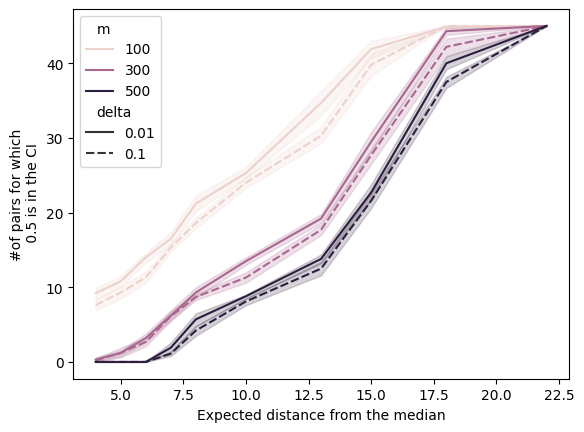

In [22]:
m = 200
n = 10
verbose = True
delta = 0.1
res = []
#theta_mm = 
repes = 10
for repe in range(repes):
  for delta in [.01,.1,]:
    for m in [100,300,500]:
      for theta_mm in np.linspace(.01,1,10):# [.01,.3,.5,.7,.9, 1]:
        center = np.arange(n) #np.random.permutation(n)
        s = sample(m=m,n=n,theta=theta_mm, s0=center)
        p_total = np.zeros((n,n)) # p_total[i,j] counts the number of times i IS PREFERRED to j
        p_ranks = s
        for perm in p_ranks:
          p, comp, _ = prank.p_rank_to_mat(perm, return_ratios=True, return_num_comparisons=True)
          p_total = p_total + p.astype('float64')
        p_total = (p_total/len(p_ranks))

        borda_rank = prank.borda_mat(p_total)
        CIs = np.zeros((n,n))
        for i in range(n):
          for j in range(i+1,n):#CI = np.sqrt( 1/(2*n_ij) * np.log( (4 * M * n_ij**2)/delta))
            CIs[i,j] = np.sqrt( 1/(2*m) * np.log( (4 * n * m**2)/delta))
            CIs[j,i] = CIs[i,j]
        #print(CIs.round(2),"CI")

        inCI = 0
        for i in range(n):
          for j in range(i+1,n):
            a = ( p_total[i,j] - CIs[i,j] )
            b = ( p_total[i,j] + CIs[i,j] )
            if a<.5 and .5<b:  
              inCI += 1
        res.append([theta_mm, delta, m, inCI, int(expected_dist_mm(n, theta_mm))])

ename='Expected distance from the median'
inCIname = '#of pairs for which\n 0.5 is in the CI'
df = pd.DataFrame(res,columns=['theta','delta','m',inCIname,ename])
sns.lineplot(data=df,hue='m',y=inCIname,x=ename,style='delta')